## Dataset Description

This dataset is synthesized by IBM from a multi-agent virtual world simulation, including synthetic consumers that travel globally. It spans decades of transactions and multiple cards per consumer. The synthetic data generated is designed to mimic real-world data as closely as possible in terms of fraud rates, purchase amounts, Merchant Category Codes (MCCs), and other metrics, thereby providing a reliable dataset for training and evaluating fraud detection models.

Though synthesized, this data has been crafted to mimic the real-world scenarios of credit card transactions, including the variances in shopping behaviors, purchase amounts, merchant variety, locations, and even fraudulent transactions, thus being a valuable resource for creating and testing credit card fraud detection models. The generation process involved intricate techniques and detailed consumer domains, resulting in a dataset that closely parallels real-world data.

This rich, synthetic dataset enables researchers and developers to explore, create, and test models in a domain where typically data availability is highly restricted due to privacy considerations. The 'natural' value columns in the dataset can be exploited for feature engineering to improve model performance.

The author's work does not involve using this data to develop and train models to predict fraud, or coupling models and the synthetic dataset to assess performance in designing accelerators such as GPUs and TPUs. Those aspects are left to the users of this dataset, offering a wide scope for exploration and innovation.

Column Descriptions

1. **User**: The unique identifier of the credit card user.
2. **Card**: The unique identifier of the credit card used for the transaction.
3. **Year**: The year when the transaction took place.
4. **Month**: The month when the transaction took place.
5. **Day**: The day when the transaction took place.
6. **Time**: The specific time when the transaction took place.
7. **Amount**: The total monetary value of the transaction.
8. **Use Chip**: Indicates whether the chip on the credit card was used for the transaction.
9. **Merchant Name**: The unique identifier of the merchant where the transaction took place.
10. **Merchant City**: The city where the merchant is located.
11. **Merchant State**: The state where the merchant is located.
12. **Zip**: The zip code of the area where the transaction took place.
13. **MCC**: The Merchant Category Code, which is a four-digit number used to categorize the type of business or service the company provides.
14. **Errors?**: Any errors that occurred during the transaction.
15. **Is Fraud?**: Indicates whether the transaction was fraudulent.

#### Citation

Altman, E.R., 2019. Synthesizing Credit Card Transactions. arXiv preprint arXiv:1910.03033. DOI: https://doi.org/10.48550/arXiv.1910.03033


## Load and merge data

In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import openpyxl
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import math
from sklearn.impute import SimpleImputer
from geopy import distance
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import ADASYN
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import AdaBoostClassifier

# Load the transactions data and drop unnecessary columns
transactions = pd.read_csv('final_dataset.csv')
transactions = transactions.drop(['Merchant State', 'Merchant City'], axis=1)
transactions = transactions.rename(columns={'Year':'Transaction Year','Month':'Transaction Month','Day':'Transaction Day','Time':'Transaction Time'})

# Convert 'Year', 'Month', 'Day' columns to datetime format and drop the original columns
transactions['datetime'] = pd.to_datetime(transactions['Transaction Year'].astype(str) + '-' + transactions['Transaction Month'].astype(str) + '-' + transactions['Transaction Day'].astype(str) + ' ' + transactions['Transaction Time'].astype(str) + ':00')
transactions = transactions.drop(['Transaction Year', 'Transaction Month', 'Transaction Day', 'Transaction Time'], axis=1)

# Load the cards data and drop unnecessary columns
cards = pd.read_csv("sd254_cards.csv")
cards = cards.drop(['CVV', 'Year PIN last Changed'], axis=1)

# Load the users data and drop unnecessary columns 
users = pd.read_csv("sd254_users.csv")
users = users.drop(['Person', 'Address','Birth Month', 'Apartment', 'City', 'State', 'Per Capita Income - Zipcode', 'Yearly Income - Person', 'Total Debt'], axis=1)
users = users.rename(columns={'latitude': 'user_latitude', 'longitude': 'user_longitude'})

# Reset index to create a 'User' column
users = users.reset_index().rename(columns={'index': 'User'})

# Load zip code data and rename columns
zip_df = pd.read_excel("zipcode_map.xlsx")
zip_df = zip_df.rename(columns={'latitude': 'merchant_latitude', 'longitude': 'merchant_longitude', 'postal code': 'Zip'})

# Merge the datasets
df = pd.merge(transactions, cards, left_on=['User', 'Card'], right_on=['User', 'CARD INDEX'], how='left')
df = pd.merge(df, users, left_on=['User'], right_on=['User'], how='left')
df = pd.merge(df, zip_df, left_on=['Zip'], right_on=['Zip'], how='left')

## Pre Processing


### Drop unwanted columns as convert data types

In [13]:
# Remove unnecessary columns and duplicate columns such as zip code since we already have long and lat we will not need these

df.drop(columns=['Card','CARD INDEX',"Zip",'Zipcode','Card Number'],inplace=True, axis=1)

# Convert money columns to float by removing dollar symbols so they can be used as inputs to model, the money symbol will make it a string

df["Amount"] = df["Amount"].str.replace("$", "", regex=False).astype(float)
df["Credit Limit"] = df["Credit Limit"].str.replace("$", "", regex=False).astype(float)
df["Is Fraud?"] = df["Is Fraud?"].apply(lambda x: 1 if x == 'Yes' else 0)

### Enrich the dataset

In [14]:
# Extract month, day of the week, and hour from the 'datetime' column
df = df.assign(Month=df['datetime'].apply(lambda x: x.month),
               DayOfWeek=df['datetime'].apply(lambda x: x.weekday()),
               Day=df['datetime'].apply(lambda x: x.day),
               Hour=df['datetime'].apply(lambda x: x.hour))

# Calculate the credit limit utilization percentage
df['CreditLimitUtilization'] = df['Amount'] / df['Credit Limit']

# Calculate the time difference in days between 'Acct Open Date' and 'datetime'
df['Acct Open Date'] = pd.to_datetime(df['Acct Open Date'], format='%m/%Y')
df['DaysSinceAcctOpen'] = (df['datetime'] - df['Acct Open Date']).dt.days

df.drop(columns=['Expires','datetime','Acct Open Date','Merchant Name','Retirement Age','datetime','Birth Year'],axis=True,inplace=True)

df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 76399 entries, 0 to 76398
Data columns (total 33 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   User                    76399 non-null  int64  
 1   Amount                  76399 non-null  float64
 2   Use Chip                76399 non-null  object 
 3   MCC                     76399 non-null  int64  
 4   Errors?                 76399 non-null  object 
 5   Is Fraud?               76399 non-null  int64  
 6   Card Brand              76399 non-null  object 
 7   Card Type               76399 non-null  object 
 8   Has Chip                76399 non-null  object 
 9   Cards Issued            76399 non-null  int64  
 10  Credit Limit            76399 non-null  float64
 11  Card on Dark Web        76399 non-null  object 
 12  Current Age             76399 non-null  int64  
 13  Gender                  76399 non-null  object 
 14  Latitude                76399 non-null

### Imputation of missing values

In [15]:
#### The Iterative Imputer, which uses a form of multiple imputation, can also capture complex patterns and is typically less computationally intensive than random forests. It fills each missing value by using a regression model that predicts the missing value using the remaining variables, and it does this in a round-robin fashion.
#### Chose iterative due to computational limitations of my system and since the data was large

imp = IterativeImputer(max_iter=10, random_state=0)

df[['Latitude', 'Longitude', 'merchant_latitude', 'merchant_longitude','accuracy']] = imp.fit_transform(df[['Latitude', 'Longitude', 'merchant_latitude', 'merchant_longitude','accuracy']])


# Create an imputer object with a most_frequent filling strategy
imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')

# List of categorical columns that have missing values
cat_cols_with_missing = ['country code', 'place name', 'admin name1', 'admin name2', 'admin code1', 'admin code2']

# Fit on the dataset and then transform it
df[cat_cols_with_missing] = imputer.fit_transform(df[cat_cols_with_missing])



# Define function to calculate Great Circle Distance
def great_circle_dist(lat1, lon1, lat2, lon2):
    coord1 = (lat1, lon1)
    coord2 = (lat2, lon2)
    return distance.great_circle(coord1, coord2).km

# Apply function to DataFrame
df['DistanceTransactionToMerchant'] = df.apply(lambda row: great_circle_dist(row['Latitude'], row['Longitude'], row['merchant_latitude'], row['merchant_longitude']), axis=1)

# Calculate direction
df['DirectionTransactionToMerchant'] = df.apply(lambda row: math.degrees(math.atan2(row['merchant_longitude'] - row['Longitude'], row['merchant_latitude'] - row['Latitude'])), axis=1)


### Encoding and Scalling

In [16]:
# Define categorical and numerical features
categorical_features = ['Use Chip', 'Errors?', 'Card Brand', 'Card Type', 'Has Chip', 'Card on Dark Web', 'Gender', 'country code', 'admin name1', 'admin code1', 'admin name2','place name']
numerical_features = ['User','Amount', 'MCC', 'Cards Issued', 'Latitude', 'Longitude', 'admin code2', 'Num Credit Cards', 'merchant_latitude', 'merchant_longitude', 'accuracy', 'Month', 'DayOfWeek', 'Day', 'Hour', 'DaysSinceAcctOpen','Current Age','DistanceTransactionToMerchant', 'DirectionTransactionToMerchant']

# Define preprocessing for numerical and categorical features
numerical_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('encoder', OneHotEncoder(handle_unknown='ignore'))])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)])

### Split Training and Testing set and performing SMOTE (Synthetic Minority Over-sampling Technique)

In [17]:
# Divide the dataset into features and labels
X = df.drop('Is Fraud?', axis=1)
y = df['Is Fraud?']

# Split your data into a training set and a test set (80-20 split here)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing: fit_transform on train data
X_train = preprocessor.fit_transform(X_train)

# Preprocessing: transform only on test data
X_test = preprocessor.transform(X_test)

# Perform Smote on training data only
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Initialize ADASYN
adasyn = ADASYN()

# Fit and apply the transform
X_train_adasyn, y_train_adasyn = adasyn.fit_resample(X_train, y_train)

print(X_train_smote)

  (0, 0)	0.5006117604630459
  (0, 1)	0.0364589409623846
  (0, 2)	0.2970111574038132
  (0, 3)	-1.088029375050352
  (0, 4)	0.8114751779104845
  (0, 5)	0.3094659158848602
  (0, 6)	0.08544910016486504
  (0, 7)	-1.7520826804273286
  (0, 8)	0.8207625468515319
  (0, 9)	0.023591298614933105
  (0, 10)	0.09243404687385018
  (0, 11)	0.9985862877695825
  (0, 12)	-0.49422412015298983
  (0, 13)	0.25891028438682256
  (0, 14)	1.2618037557066253
  (0, 15)	-0.038351802066075504
  (0, 16)	-1.72802363680403
  (0, 17)	0.29868924315884393
  (0, 18)	-0.8515515607149092
  (0, 19)	1.0
  (0, 30)	1.0
  (0, 34)	1.0
  (0, 36)	1.0
  (0, 39)	1.0
  (0, 40)	1.0
  :	:
  (121865, 40)	1.0
  (121865, 39)	1.0
  (121865, 37)	0.7012011412042706
  (121865, 34)	0.7012011412042706
  (121865, 22)	0.7012011412042706
  (121865, 19)	0.7012011412042706
  (121865, 18)	-1.090735697609589
  (121865, 17)	-0.280581329215795
  (121865, 16)	0.02974917935993321
  (121865, 15)	-0.05468459472498696
  (121865, 14)	0.3205775887530061
  (121865,

## Feature Selection

[LightGBM] [Info] Number of positive: 186, number of negative: 60933
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007321 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3882
[LightGBM] [Info] Number of data points in the train set: 61119, number of used features: 933
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.003043 -> initscore=-5.791784
[LightGBM] [Info] Start training from score -5.791784
Feature: DistanceTransactionToMerchant, Score: 280.00000
Feature: DaysSinceAcctOpen, Score: 256.00000
Feature: merchant_latitude, Score: 237.00000
Feature: MCC, Score: 211.00000
Feature: Amount, Score: 194.00000
Feature: Hour, Score: 173.00000
Feature: DirectionTransactionToMerchant, Score: 165.00000
Feature: User, Score: 163.00000
Feature: merchant_longitude, Score: 152.00000
Feature: Current Age, Score: 137.00000
Feature: Day, Score: 

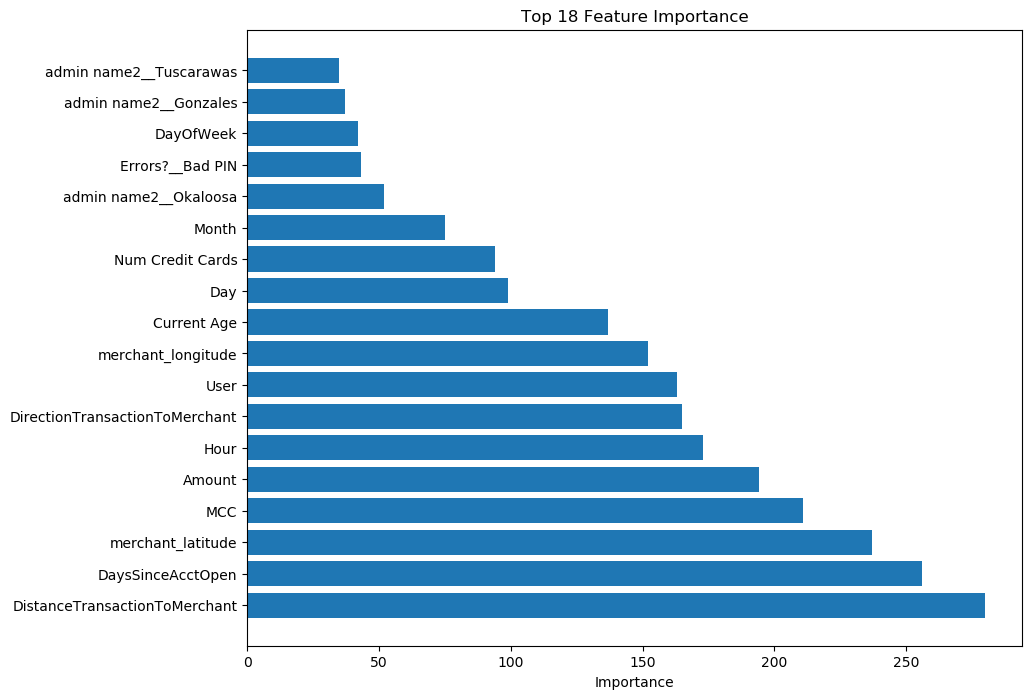

In [32]:
import lightgbm as lgb
import matplotlib.pyplot as plt
import pandas as pd

# train the LightGBM model
model = lgb.LGBMClassifier(objective='binary', random_state=42)
model.fit(X_train_f, y_train_f)

# get feature importance
importance = model.feature_importances_

# Get the list of categorical features after one-hot encoding
ohe_categories = preprocessor.named_transformers_['cat'].named_steps['encoder'].categories_
new_ohe_features = [f"{col}__{val}" for col, vals in zip(categorical_features_f, ohe_categories) for val in vals]

# Combine the numerical and new one-hot encoded features
feature_names = numerical_features_f + new_ohe_features

# create a DataFrame with feature importance
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Score': importance
})

# Save all feature importance scores to a csv file
importance_df.to_csv('feature_importance.csv', index=False)

# sort the DataFrame by 'Score' in descending order and select the top 12
top_18_features = importance_df.sort_values('Score', ascending=False).head(18)

# Print the top 12 feature importance scores
for index, row in top_18_features.iterrows():
    print('Feature: %s, Score: %.5f' % (row['Feature'], row['Score']))

# plot feature importance of the top 12 features
plt.figure(figsize=(10, 8))
plt.barh(top_18_features['Feature'], top_18_features['Score'])
plt.xlabel('Importance')
plt.title('Top 18 Feature Importance')
plt.show()


In [18]:
# Divide the dataset into features and labels
feature_X = df.drop('Is Fraud?', axis=1)
feature_y = df['Is Fraud?']

# Split your data into a training set and a test set (80-20 split here)
X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(feature_X, feature_y, test_size=0.2, random_state=42)

# Define categorical and numerical features
categorical_features_f = ['Errors?','Card Type', 'Has Chip', 'Gender', 'country code', 'admin name1', 'admin name2','place name']
numerical_features_f = ['User','Amount', 'MCC', 'Num Credit Cards', 'merchant_latitude', 'merchant_longitude', 'Month', 'DayOfWeek', 'Day', 'Hour', 'DaysSinceAcctOpen','Current Age','DistanceTransactionToMerchant', 'DirectionTransactionToMerchant']

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features_f),
        ('cat', categorical_transformer, categorical_features_f)])


# Preprocessing: fit_transform on train data
X_train_f = preprocessor.fit_transform(X_train_f)

# Preprocessing: transform only on test data
X_test_f = preprocessor.transform(X_test_f)

# Initialize ADASYN
adasyn = ADASYN()

# Fit and apply the transform
X_train_adasyn_f, y_train_adasyn_f = adasyn.fit_resample(X_train_f, y_train_f)

print(X_train_adasyn)


  (0, 0)	0.5006117604630459
  (0, 1)	0.0364589409623846
  (0, 2)	0.2970111574038132
  (0, 3)	-1.088029375050352
  (0, 4)	0.8114751779104845
  (0, 5)	0.3094659158848602
  (0, 6)	0.08544910016486504
  (0, 7)	-1.7520826804273286
  (0, 8)	0.8207625468515319
  (0, 9)	0.023591298614933105
  (0, 10)	0.09243404687385018
  (0, 11)	0.9985862877695825
  (0, 12)	-0.49422412015298983
  (0, 13)	0.25891028438682256
  (0, 14)	1.2618037557066253
  (0, 15)	-0.038351802066075504
  (0, 16)	-1.72802363680403
  (0, 17)	0.29868924315884393
  (0, 18)	-0.8515515607149092
  (0, 19)	1.0
  (0, 30)	1.0
  (0, 34)	1.0
  (0, 36)	1.0
  (0, 39)	1.0
  (0, 40)	1.0
  :	:
  (121889, 40)	1.0
  (121889, 39)	0.07463443377913814
  (121889, 36)	0.07463443377913814
  (121889, 34)	1.0
  (121889, 22)	0.07463443377913814
  (121889, 20)	1.0
  (121889, 18)	1.621297123041503
  (121889, 17)	-0.29420819988547436
  (121889, 16)	0.3616873556862198
  (121889, 15)	0.07850360207407081
  (121889, 14)	-0.9554457100008418
  (121889, 13)	-1.1958

## Finding best parameters

### Logistic Regression

In [ ]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Define the model parameters for Grid Search
lr_params = {'penalty': ['l1', 'l2', 'elasticnet', 'none'], 'C': [0.001,0.01,0.1,1,10,100], 'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}

# Initialize the Logistic Regression model
lr_model = LogisticRegression()

# Use GridSearchCV to find the best parameters
lr_grid = GridSearchCV(lr_model, lr_params, cv=5, scoring='recall',verbose=0, n_jobs=-1)

# Fit the data to GridSearchCV
lr_grid.fit(X_train_smote, y_train_smote)

# Print the best parameters
print("Best parameters found: ", lr_grid.best_params_)

# Best parameters found:  {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}

### When the warning One or more of the test scores are non-finite appears, it means that the scoring function returned NaN (not a number) for one or more combinations of hyperparameters. This typically happens when a model fails to converge, or perhaps due to an inappropriate combination of hyperparameters. In this context, NaN values are ignored, and the best parameters are chosen among those that provided valid (finite) scores.

### However, you might want to investigate why these scores are non-finite and possibly adjust your hyperparameters to prevent these cases. You might also want to consider normalizing or standardizing your features, handling missing values or outliers, or choosing different hyperparameters or a different solver.

### Random Forest Classifier

In [19]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint

# Instantiate the RandomForestClassifier
rf_model = RandomForestClassifier(random_state=0)

# Define the parameters grid
param_dist = {
    'n_estimators': randint(50, 200),
    'max_features': ['sqrt',None],
    'max_depth': randint(10, 30)
}

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=rf_model, param_distributions=param_dist, 
                                   n_iter=10, cv=3, scoring='f1', verbose=2, n_jobs=-1, random_state=0)

# Fit the model
random_search.fit(X_train_adasyn, y_train_adasyn)

# Get the best parameters
best_params = random_search.best_params_

print(f"Best parameters found:  {best_params}")

# Best parameters found:  {'max_depth': 22, 'max_features': None, 'n_estimators': 167}

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters found:  {'max_depth': 29, 'max_features': 'sqrt', 'n_estimators': 129}


### XG Boost

In [18]:
# Define our parameters 
parameters = {
    'learning_rate': [0.01, 0.1, 0.2, 0.3], 
    'max_depth': [3, 4, 5, 6, 7],
    'n_estimators': [100, 200, 300, 400, 500],
    'min_child_weight': [1, 2, 3, 4]
}

xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Use RandomizedSearchCV and early stopping
random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=parameters, cv=3, scoring='recall', n_jobs=-1, n_iter=50)
random_search.fit(X_train_f, y_train_f, early_stopping_rounds=10, eval_set=[(X_test_f, y_test_f)])

# Print the best parameters and highest recall
print(f"Best parameters found:  {random_search.best_params_}")
print(f"Best recall found:  {random_search.best_score_}")


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,


[0]	validation_0-logloss:0.51344
[1]	validation_0-logloss:0.39270
[2]	validation_0-logloss:0.30615
[3]	validation_0-logloss:0.24173
[4]	validation_0-logloss:0.19262
[5]	validation_0-logloss:0.15455
[6]	validation_0-logloss:0.12465
[7]	validation_0-logloss:0.10098
[8]	validation_0-logloss:0.08212
[9]	validation_0-logloss:0.06700
[10]	validation_0-logloss:0.05483
[11]	validation_0-logloss:0.04501
[12]	validation_0-logloss:0.03707
[13]	validation_0-logloss:0.03063
[14]	validation_0-logloss:0.02539
[15]	validation_0-logloss:0.02113
[16]	validation_0-logloss:0.01766
[17]	validation_0-logloss:0.01484
[18]	validation_0-logloss:0.01256
[19]	validation_0-logloss:0.01071
[20]	validation_0-logloss:0.00920
[21]	validation_0-logloss:0.00796
[22]	validation_0-logloss:0.00692
[23]	validation_0-logloss:0.00609
[24]	validation_0-logloss:0.00538
[25]	validation_0-logloss:0.00478
[26]	validation_0-logloss:0.00435
[27]	validation_0-logloss:0.00399
[28]	validation_0-logloss:0.00366
[29]	validation_0-loglos

### Ada Boost

In [19]:
# Define the parameters for the random search
adaboost_params = {
    'n_estimators': [50, 100, 200, 400],
    'learning_rate': np.logspace(-3, 1, 5)  # equivalent to [0.001, 0.01, 0.1, 1, 10]
}

# Initialize the AdaBoost Classifier
adaboost_model = AdaBoostClassifier()

# Set up the random search
adaboost_random = RandomizedSearchCV(adaboost_model, adaboost_params, cv=5, scoring='recall', n_iter=10, verbose=0, n_jobs=-1, random_state=42)

# Fit the random search to the data
adaboost_random.fit(X_train_smote, y_train_smote)

# Print the best parameters
print("Best parameters found: ", adaboost_random.best_params_)


Best parameters found:  {'n_estimators': 400, 'learning_rate': 1.0}


## Models with best parameters

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelBinarizer


# Instantiate the model with the best parameters
lr_model = LogisticRegression(C=1, penalty='l1', solver='liblinear', random_state=0)

# Fit the model to the training data
lr_model.fit(X_train_smote, y_train_smote)

# Predict the labels of the test set
y_pred_lr = lr_model.predict(X_test)

# Evaluate the model
print('Logistic Regression performance:')
print('Accuracy:', accuracy_score(y_test, y_pred_lr))
print('Precision:', precision_score(y_test, y_pred_lr))
print('Recall:', recall_score(y_test, y_pred_lr))
print('F1 Score:', f1_score(y_test, y_pred_lr))

# convert labels to binary
lb = LabelBinarizer()
y_test_bin = lb.fit_transform(y_test)
y_pred_lr_bin = lb.transform(y_pred_lr)

print('ROC AUC Score:', roc_auc_score(y_test_bin, y_pred_lr_bin))


Logistic Regression performance:
Accuracy: 0.9943062827225131
Precision: 0.24528301886792453
Recall: 0.7878787878787878
F1 Score: 0.37410071942446044
ROC AUC Score: 0.8913159270278703


the model trained on the SMOTE-augmented data has a lower accuracy, but it's much better at identifying the minority class (the fraud cases), as indicated by the much higher recall of 0.788. The trade-off is that it's also predicting more false positives, which is why the precision has dropped significantly.

This is the key trade-off in fraud detection: do you want to catch more of the fraud cases at the risk of more false positives (SMOTE model), or do you want to minimize false positives at the risk of missing some fraud cases (original model)? This largely depends on the specific business context. For example, in some situations, a false negative (a fraud case that goes undetected) might be much more costly than a false positive (a legitimate transaction that gets flagged as potential fraud).

The ROC AUC (Receiver Operating Characteristic Area Under the Curve) score is often a better metric for imbalanced classification problems because it's insensitive to imbalanced classes. It measures the trade-off between the True Positive Rate (TPR, which is the same as recall) and the False Positive Rate (FPR), at various threshold settings. The fact that your SMOTE model has a higher ROC AUC score indicates that it's doing a better job overall at distinguishing between the classes, despite the lower accuracy and precision.

In [12]:
# Instantiate the model with the best parameters
rf_model = RandomForestClassifier(max_depth=19, max_features=None, n_estimators=71, random_state=42)

# Fit the model to the training data
rf_model.fit(X_train_f, y_train_f)

# Predict the labels of the test set
y_pred_r = rf_model.predict(X_test_f)

# Print performance metrics
print("Random Forest performance:")
print('Accuracy:', accuracy_score(y_test_f, y_pred_r))
print('Precision:', precision_score(y_test_f, y_pred_r))
print('Recall:', recall_score(y_test_f, y_pred_r))
print('F1 Score:', f1_score(y_test_f, y_pred_r))

### The Slected Features Perform Better!!

Random Forest performance:
Accuracy: 0.99967277486911
Precision: 0.9375
Recall: 0.9090909090909091
F1 Score: 0.923076923076923


In [10]:
# Fit the model with best parameters
best_xgb_model = xgb.XGBClassifier(
    n_estimators=300, 
    min_child_weight=2, 
    max_depth=7, 
    learning_rate=0.2,
    use_label_encoder=False,
    eval_metric='logloss'
)

best_xgb_model.fit(X_train_f, y_train_f)

# Predict the response for test dataset
y_pred_xgb = best_xgb_model.predict(X_test_f)

# Performance
print("XGBoost performance:")
print(f"Accuracy: {accuracy_score(y_test_f, y_pred_xgb)}")
print(f"Precision: {precision_score(y_test_f, y_pred_xgb)}")
print(f"Recall: {recall_score(y_test_f, y_pred_xgb)}")
print(f"F1 Score: {f1_score(y_test_f, y_pred_xgb)}")
print(f"ROC AUC Score: {roc_auc_score(y_test_f, best_xgb_model.predict_proba(X_test_f)[:, 1])}")


XGBoost performance:
Accuracy: 0.99967277486911
Precision: 1.0
Recall: 0.8484848484848485
F1 Score: 0.9180327868852458
ROC AUC Score: 0.9942720972431736


In [21]:
# Initialize the AdaBoost Classifier with the best parameters
adaboost_model = AdaBoostClassifier(n_estimators=400, learning_rate=1.0,random_state=42)

# Fit the model to the data
adaboost_model.fit(X_train_adasyn, y_train_adasyn)

# You can now use this model to make predictions on unseen data
# For example, to predict on your test set you can use:
y_pred_ada = adaboost_model.predict(X_test)

# Calculate the scores
accuracy = accuracy_score(y_test, y_pred_ada)
precision = precision_score(y_test, y_pred_ada)
recall = recall_score(y_test, y_pred_ada)
f1 = f1_score(y_test, y_pred_ada)
roc_auc = roc_auc_score(y_test, y_pred_ada)

# Print the scores
print('Accuracy: ', accuracy)
print('Precision: ', precision)
print('Recall: ', recall)
print('F1 Score: ', f1)
print('ROC AUC Score: ', roc_auc)

Accuracy:  0.999607329842932
Precision:  0.9354838709677419
Recall:  0.8787878787878788
F1 Score:  0.90625
ROC AUC Score:  0.9393283527211512
